In [ ]:
from sqlalchemy import create_engine, text
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import math

In [ ]:
query = '''
WITH cte AS(
    SELECT 
        companyname,
        EXTRACT('MONTH' FROM pubtimestamp) AS month,
        EXTRACT('DAY' FROM pubtimestamp) AS day,
        COUNT(DISTINCT sumdid) AS trp_day
    FROM trips
    WHERE EXTRACT('MONTH' FROM pubtimestamp) <> 8
        AND tripduration < 1440
        AND tripduration > 1
        AND tripdistance > 0
        AND sumdid IN (SELECT
                    sumdid
                    FROM scooters
                    WHERE sumdgroup <> 'bicycle')
    GROUP BY EXTRACT('MONTH' FROM pubtimestamp), EXTRACT('DAY' FROM pubtimestamp), companyname
)
SELECT
    CASE
        WHEN cte.month = 5 THEN 'May'
        WHEN cte.month = 6 THEN 'June'
        WHEN cte.month = 7 THEN 'July'
    END AS month,
    companyname,
    CASE 
        WHEN month = 6 THEN AVG(trp_day)/30
        ELSE AVG(trp_day)/31
    END AS avg_trips_per_day
FROM cte
GROUP BY month, companyname
ORDER BY month
'''

with engine.connect() as connection:
    comp_mnth_avg_trps = pd.read_sql(text(query), con = connection)

In [ ]:
comp_mnth_avg_trps.head()

,month,companyname,avg_trips_per_day
0,July,Lyft,10.637877
1,July,Lime,10.462019
2,July,JUMP,2.858065
3,July,Bolt Mobility,2.491155
4,July,Gotcha,0.605313


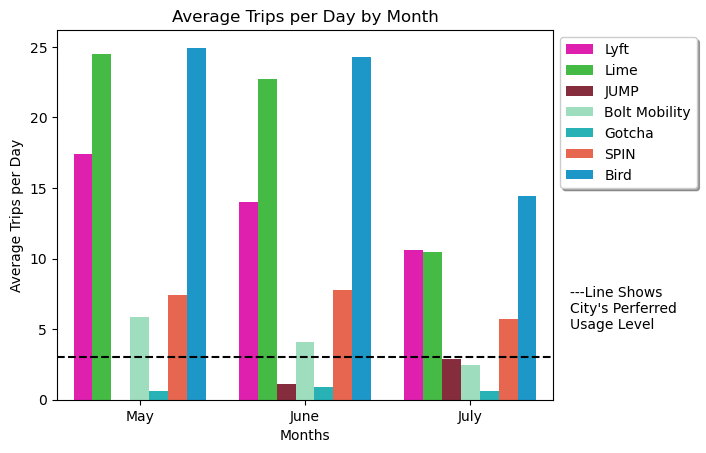

In [ ]:
ax = sns.barplot(data=comp_mnth_avg_trps, x="month", y="avg_trips_per_day", hue="companyname",
            palette=trip_company_colors, order=["May", "June", "July"]
            ).set(title = 'Average Trips per Day by Month',)
plt.axhline(y = 3, xmin = 0, xmax = 1,
           color = "black", linestyle = "dashed")
plt.text( 2.6, 5, "---Line Shows\nCity's Perferred\nUsage Level")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True)
plt.xlabel('Months')
plt.ylabel('Average Trips per Day')
plt.savefig('../images/avg_trips_per_day.png', format = 'png', bbox_inches = 'tight')
plt.show()

Average Cost

In [ ]:
query = '''
WITH cte AS(
    SELECT
        EXTRACT('MONTH' FROM pubdatetime) AS month,
        companyname,
        AVG(costpermin) AS avg_cost
    FROM scooters
    WHERE sumdid IN (SELECT
                sumdid
                FROM scooters
                WHERE sumdgroup <> 'bicycle')
    GROUP BY EXTRACT('MONTH' FROM pubdatetime),companyname
)
SELECT 
    CASE
        WHEN cte.month = 5 THEN 'May'
        WHEN cte.month = 6 THEN 'June'
        WHEN cte.month = 7 THEN 'July'
    END AS month,
    companyname,
    avg_cost
FROM cte
'''

with engine.connect() as connection:
    avg_cst_per_min = pd.read_sql(text(query), con = connection)

In [ ]:
avg_cst_per_min

,month,companyname,avg_cost
0,May,Bird,0.050842
1,May,Bolt,0.150000
2,May,Gotcha,0.080343
3,May,Jump,0.055114
4,May,Lime,0.052648
5,May,Lyft,0.042968
6,May,Spin,0.152082
7,June,Bird,0.150000
8,June,Bolt,0.150000
9,June,Gotcha,0.150000


ax= plt.subplot()
labels = ['1','2', '', '4', '', '6', '']
ax.set_yticklabels(labels);





1:34
those labels would obviously be what you want them to be

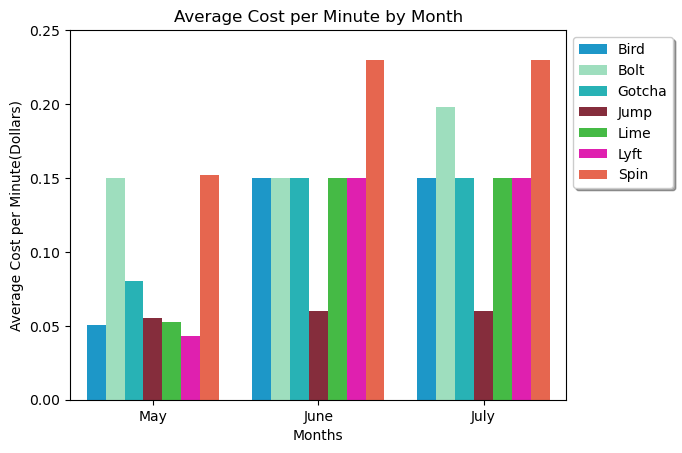

In [ ]:
sns.barplot(data=avg_cst_per_min, x="month", y="avg_cost", hue="companyname",
            palette=scoot_company_colors, order=["May", "June", "July"]
            ).set(title = 'Average Cost per Minute by Month',)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True)
plt.xlabel('Months')
plt.ylabel('Average Cost per Minute(Dollars)')
plt.yticks(np.arange(0, 0.30, 0.05))
plt.savefig('../images/avg_cost_mnth.png', format = 'png', bbox_inches = 'tight')
plt.show()

In [ ]:
query = '''
    SELECT
        companyname,
        ROUND(AVG(costpermin), 2) AS avg_cost
    FROM scooters
    GROUP BY companyname
'''

with engine.connect() as connection:
    avg_cst_scoot = pd.read_sql(text(query), con = connection)

In [ ]:
avg_cst_scoot

,companyname,avg_cost
0,Bird,0.11
1,Bolt,0.17
2,Gotcha,0.14
3,Jump,0.06
4,Lime,0.11
5,Lyft,0.11
6,Spin,0.21


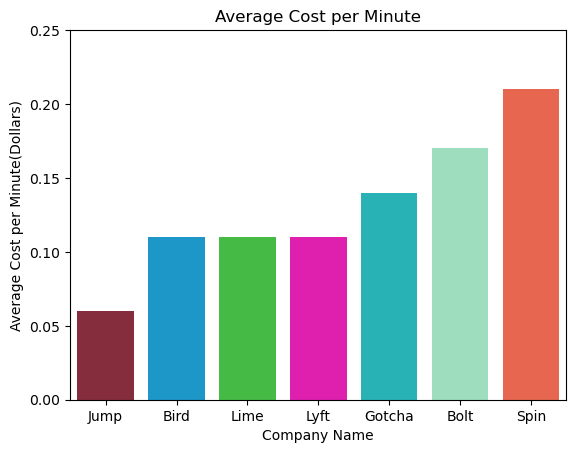

In [ ]:
sns.barplot(data=avg_cst_scoot, x="companyname", y="avg_cost",
            palette=scoot_company_colors, order=avg_cst_scoot.sort_values(by = 'avg_cost').companyname
            ).set(title = 'Average Cost per Minute',)
# ax= plt.subplot()
# labels = ['0.00', '', '0.05', '', '0.10', '', '0.15', '', '0.20']
# ax.set_yticklabels(labels)
plt.xlabel('Company Name')
plt.ylabel('Average Cost per Minute(Dollars)')
plt.yticks(np.arange(0, 0.30, 0.05))
plt.savefig('../images/avg_cost.png', format = 'png', bbox_inches = 'tight')
plt.show()

Total Monthly Revenue

In [ ]:
query = '''
WITH cte1 AS(
    SELECT
        ROW_NUMBER() OVER (ORDER BY (SELECT 1)) AS index,
        EXTRACT('MONTH' FROM pubdatetime) AS month,
        companyname,
        AVG(costpermin) AS avg_cost
    FROM scooters
    WHERE sumdid IN (SELECT
                    sumdid
                    FROM scooters
                    WHERE sumdgroup <> 'bicycle')
    GROUP BY EXTRACT('MONTH' FROM pubdatetime), companyname
),
cte2 AS(
    SELECT
        ROW_NUMBER() OVER (ORDER BY (SELECT 1)) AS index,
        EXTRACT('MONTH' FROM pubtimestamp) AS month,
        companyname,
        AVG(tripduration) AS avg_dur,
        COUNT(DISTINCT sumdid) as mnth_trips
    FROM trips
    WHERE EXTRACT('MONTH' FROM pubtimestamp) <> 8
        AND tripduration < 1440
        AND tripduration > 1
        AND tripdistance > 0
        AND sumdid IN (SELECT
                    sumdid
                    FROM scooters
                    WHERE sumdgroup <> 'bicycle')
    
    GROUP BY EXTRACT('MONTH' FROM pubtimestamp), companyname
)
SELECT
    CASE
        WHEN cte1.month = 5 THEN 'May'
        WHEN cte1.month = 6 THEN 'June'
        WHEN cte1.month = 7 THEN 'July'
    END AS month,
    cte1.companyname,
    ROUND(avg_cost,2),
    avg_dur,
    ROUND((avg_cost * avg_dur), 2) AS avg_cost_per_trip,
    mnth_trips,
    ROUND(((avg_cost * avg_dur)*mnth_trips), 2) AS tot_mnth_rev   
FROM cte1
LEFT JOIN cte2
USING(index)
'''

with engine.connect() as connection:
    mnth_tot_rev = pd.read_sql(text(query), con = connection)

In [ ]:
mnth_tot_rev

,month,companyname,round,avg_dur,avg_cost_per_trip,mnth_trips,tot_mnth_rev
0,May,Bird,0.05,16.064870,0.82,2848.0,2326.18
1,May,Bolt,0.15,649.393732,97.41,340.0,33119.08
2,May,Gotcha,0.08,12.930038,1.04,98.0,101.81
3,May,Jump,0.06,16.734797,0.92,1566.0,1444.35
4,May,Lime,0.05,17.209599,0.91,1359.0,1231.32
5,May,Lyft,0.04,21.994539,0.95,636.0,601.05
6,May,Spin,0.15,17.787537,2.71,2700.0,7303.95
7,June,Bird,0.15,642.430394,96.36,329.0,31703.94
8,June,Bolt,0.15,11.859761,1.78,129.0,229.49
9,June,Gotcha,0.15,49.285065,7.39,165.0,1219.81


C:\Users\jdejr\AppData\Local\Temp\ipykernel_18128\3965003989.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


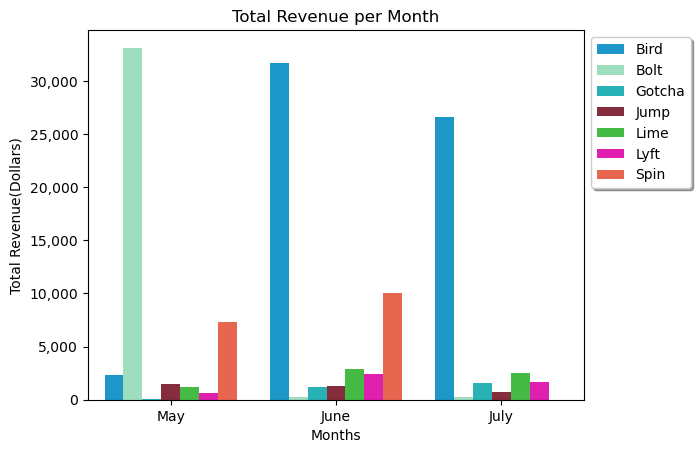

In [ ]:
sns.barplot(data=mnth_tot_rev, x="month", y="tot_mnth_rev", hue="companyname",
            palette=scoot_company_colors, order=["May", "June", "July"]
            ).set(title = 'Total Revenue per Month',)
ax= plt.subplot()
labels = ['0', '5,000', '10,000', '15,000', '20,000', '25,000', '30,000']
ax.set_yticklabels(labels)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True)
plt.xlabel('Months')
plt.ylabel('Total Revenue(Dollars)')
##plt.yticks(np.arange(0, 0.30, 0.05))
plt.savefig('../images/tot_rev_mnth.png', format = 'png', bbox_inches = 'tight')
plt.show()

In [ ]:
inliers = mnth_tot_rev[(mnth_tot_rev['companyname'] != 'Bolt') & (mnth_tot_rev['companyname'] != 'Bird')]

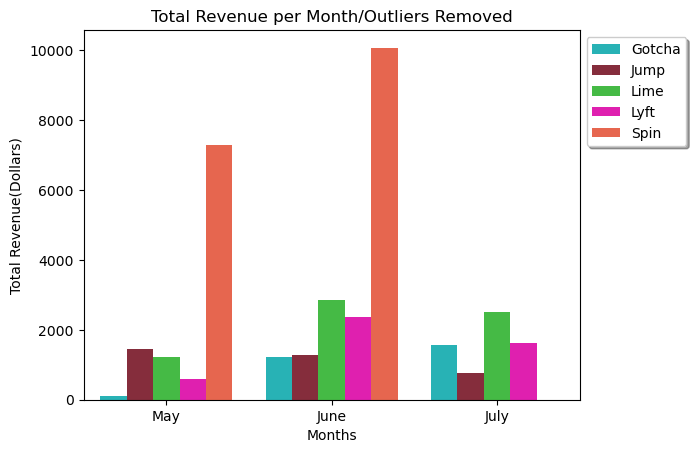

In [ ]:
sns.barplot(data=inliers, x="month", y="tot_mnth_rev", hue="companyname",
            palette=scoot_company_colors, order=["May", "June", "July"]
            ).set(title = 'Total Revenue per Month/Outliers Removed',)
# ax= plt.subplot()
# labels = ['0', '2,000', '4,000', '6,000', '8,000', '10,000']
# ax.set_yticklabels(labels)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True)
plt.xlabel('Months')
plt.ylabel('Total Revenue(Dollars)')
##plt.yticks(np.arange(0, 0.30, 0.05))
plt.savefig('../images/tot_rev_mnth_inliers.png', format = 'png', bbox_inches = 'tight')
plt.show()

Compliance

In [ ]:
query = '''
SELECT 
    companyname,
    CASE
        WHEN tripduration > 1440 OR tripduration < 1 OR tripdistance < 0 THEN 'Noncompliant'
        ELSE 'Compliant'
    END AS compliance
FROM trips
WHERE EXTRACT('MONTH' FROM pubtimestamp) <> 8
    AND sumdid IN (SELECT
                    sumdid
                    FROM scooters
                    WHERE sumdgroup <> 'bicycle')
'''

trip_compliance = pd.read_sql(query, con = engine)

In [ ]:
trip_compliance

,companyname,compliance
0,Lyft,Compliant
1,Lyft,Compliant
2,Lyft,Compliant
3,Lyft,Noncompliant
4,Lyft,Compliant
...,...,...
559745,Bird,Compliant
559746,Bird,Compliant
559747,Bird,Compliant
559748,Bird,Compliant


In [ ]:
bird_compliance = trip_compliance[trip_compliance['companyname'] == 'Bird']
bolt_compliance = trip_compliance[trip_compliance['companyname'] == 'Bolt Mobility']
gotcha_compliance = trip_compliance[trip_compliance['companyname'] == 'Gotcha']
jump_compliance = trip_compliance[trip_compliance['companyname'] == 'JUMP']
lime_compliance = trip_compliance[trip_compliance['companyname'] == 'Lime']
lyft_compliance = trip_compliance[trip_compliance['companyname'] == 'Lyft']
spin_compliance = trip_compliance[trip_compliance['companyname'] == 'SPIN']

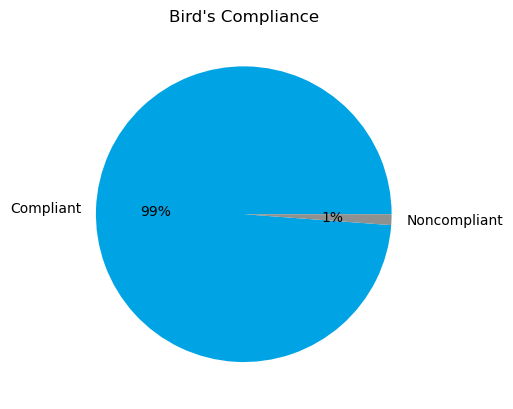

In [ ]:
bird = bird_compliance.value_counts()
colors = ['#00a4e4', '#8e918f']
labels = ['Compliant', 'Noncompliant']
plt.title("Bird's Compliance")
plt.pie(bird,labels = labels, autopct='%1.0f%%', colors = colors)
plt.savefig('../images/bird_compl.png', format = 'png', bbox_inches = 'tight')
plt.show()

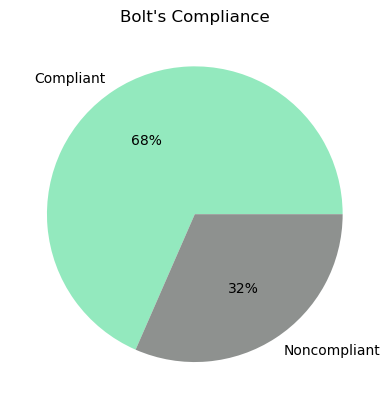

In [ ]:
bolt = bolt_compliance.value_counts()
colors = ['#93E9BE', '#8e918f']
labels = ['Compliant', 'Noncompliant']
plt.title("Bolt's Compliance")
plt.pie(bolt, labels = labels, autopct='%1.0f%%', colors = colors)
plt.savefig('../images/bolt_compl.png', format = 'png', bbox_inches = 'tight')
plt.show()

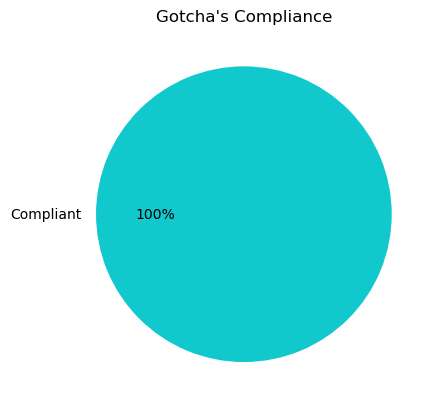

In [ ]:
gotcha = gotcha_compliance.value_counts()
colors = [ '#11C8CC', '#8e918f']
labels = ['Compliant']
plt.title("Gotcha's Compliance")
plt.pie(gotcha, labels = labels, autopct='%1.0f%%', colors = colors)
plt.savefig('../images/got_compl.png', format = 'png', bbox_inches = 'tight')
plt.show()

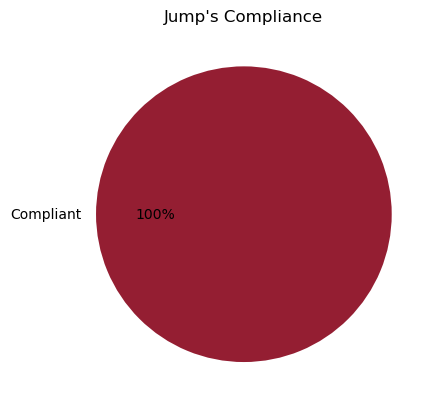

In [ ]:
jump = jump_compliance.value_counts()
colors = [ '#941E32', '#8e918f']
labels = ['Compliant']
plt.title("Jump's Compliance")
plt.pie(jump, labels = labels, autopct='%1.0f%%', colors = colors)
plt.savefig('../images/jmp_compl.png', format = 'png', bbox_inches = 'tight')
plt.show()

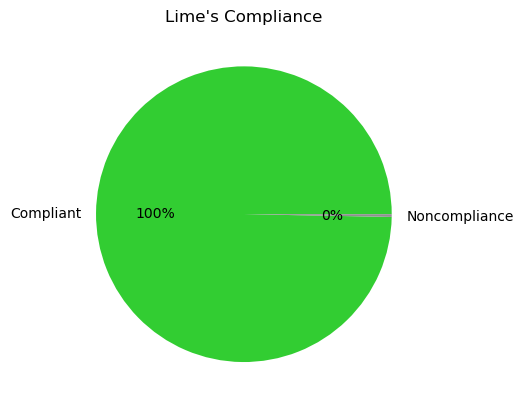

In [ ]:
lime = lime_compliance.value_counts()
colors = ['#32CD32', '#8e918f']
labels = ['Compliant', 'Noncompliance']
plt.title("Lime's Compliance")
plt.pie(lime, labels = labels, autopct='%1.0f%%', colors = colors)
plt.savefig('../images/lime_compl.png', format = 'png', bbox_inches = 'tight')
plt.show()

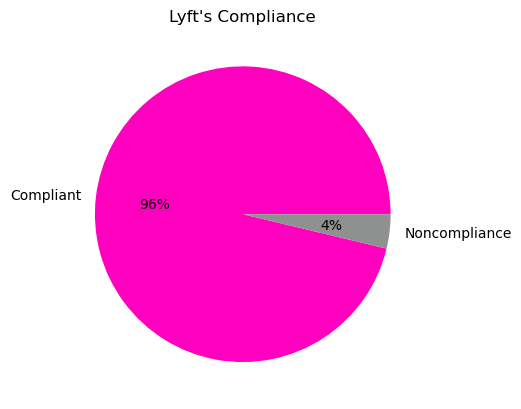

In [ ]:
lyft = lyft_compliance.value_counts()
colors = ['#FF00BF', '#8e918f']
labels = ['Compliant', 'Noncompliance']
plt.title("Lyft's Compliance")
plt.pie(lyft, labels = labels, autopct='%1.0f%%', colors = colors)
plt.savefig('../images/lyft_compl.png', format = 'png', bbox_inches = 'tight')
plt.show()

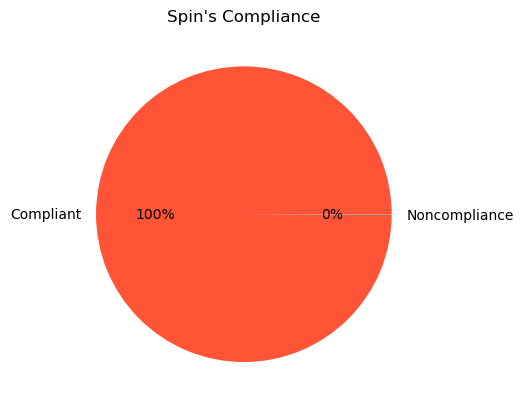

In [ ]:
spin = spin_compliance.value_counts()
colors = ['#FF5436', '#8e918f']
labels = ['Compliant', 'Noncompliance']
plt.title("Spin's Compliance")
plt.pie(spin, labels = labels, autopct='%1.0f%%', colors = colors)
plt.savefig('../images/spin_compl.png', format = 'png', bbox_inches = 'tight')
plt.show()

Duration and Scooter Count

In [ ]:
query = '''
SELECT
    CASE
        WHEN EXTRACT('MONTH' FROM pubtimestamp) = 5 THEN 'May'
        WHEN EXTRACT('MONTH' FROM pubtimestamp) = 6 THEN 'June'
        WHEN EXTRACT('MONTH' FROM pubtimestamp) = 7 THEN 'July'
    END AS month,
    companyname,
    SUM(tripduration)
FROM trips
WHERE EXTRACT('MONTH' FROM pubtimestamp) <>8
    AND tripduration < 1440
        AND tripduration > 1
        AND tripdistance > 0
        AND sumdid IN (SELECT
                    sumdid
                    FROM scooters
                    WHERE sumdgroup <> 'bicycle')
GROUP BY EXTRACT('MONTH' FROM pubtimestamp), companyname
'''

tot_dur = pd.read_sql(query, con = engine)

In [ ]:
tot_dur

,month,companyname,sum
0,May,Bird,6.693910e+05
1,May,Bolt Mobility,2.279372e+06
2,May,Gotcha,6.736550e+03
3,May,Lime,1.628112e+06
4,May,Lyft,8.705648e+05
5,May,SPIN,1.852600e+05
6,June,Bird,5.654480e+05
7,June,Bolt Mobility,4.531704e+06
8,June,Gotcha,1.820473e+04
9,June,JUMP,1.976331e+04


In [ ]:
data = data=tot_dur[tot_dur['month'] == 'May']
data

,month,companyname,sum
0,May,Bird,6.693910e+05
1,May,Bolt Mobility,2.279372e+06
2,May,Gotcha,6.736550e+03
3,May,Lime,1.628112e+06
4,May,Lyft,8.705648e+05
5,May,SPIN,1.852600e+05


C:\Users\jdejr\AppData\Local\Temp\ipykernel_18128\2119337570.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


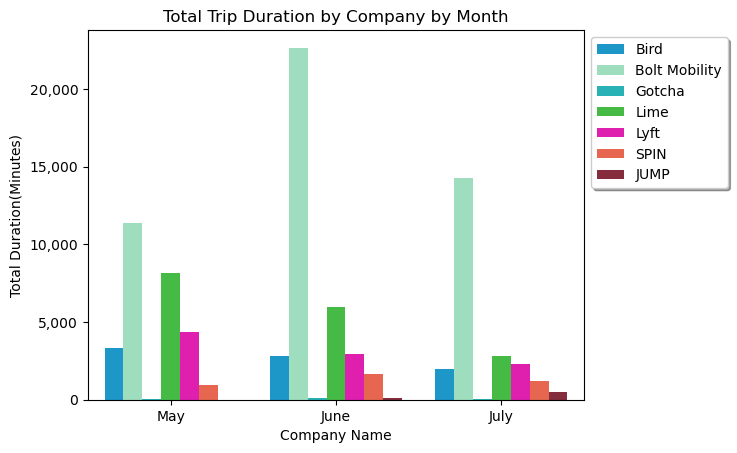

In [ ]:
data = tot_dur
sns.barplot(data=data, x="month", y="sum", hue = 'companyname',
            palette=trip_company_colors, order=['May', 'June', 'July']
            ).set(title = "Total Trip Duration by Company by Month",)
ax= plt.subplot()
labels = ['0', '5,000', '10,000', '15,000', '20,000', '25,000']
ax.set_yticklabels(labels)
# axe = plt.gca()
# axe.set_ylim([0, 5000000])
plt.xlabel('Company Name')
plt.ylabel('Total Duration(Minutes)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True)
plt.savefig('../images/tot_dur.png', format = 'png', bbox_inches = 'tight')
plt.show()

C:\Users\jdejr\AppData\Local\Temp\ipykernel_18128\2031357939.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


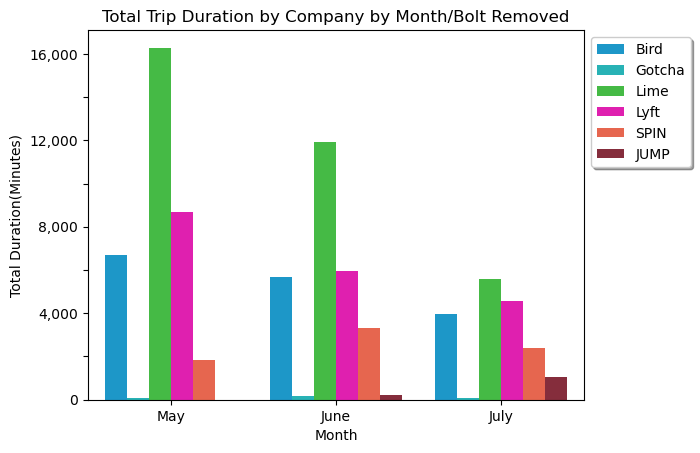

In [ ]:
data = tot_dur[tot_dur['companyname'] != 'Bolt Mobility']
sns.barplot(data=data, x="month", y="sum", hue = 'companyname',
            palette=trip_company_colors, order=['May', 'June', 'July']
            ).set(title = "Total Trip Duration by Company by Month/Bolt Removed",)
ax= plt.subplot()
labels = ['0', '', '4,000', '', '8,000', '', '12,000', '', '16,000']
ax.set_yticklabels(labels)
plt.xlabel('Month')
plt.ylabel('Total Duration(Minutes)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), shadow=True)
plt.savefig('../images/tot_dur_boltless.png', format = 'png', bbox_inches = 'tight')
plt.show()